In [1]:
# The standard Python science stack
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
# For projections (wrapped for Proj)
import pyproj

# Plotting maps using GMT
# import pygmt

# The Fatiando stack
import pooch
import verde as vd
import boule as bl
import harmonica as hm

figheight=180 # in mm
# ris_xl= -400_000
# ris_yl= -500_000 #N extent
# ris_xh= -150_000
# ris_yh= -400_000 #S extent
ris_xl= -760_000
ris_yl= -1600_000 #N extent
ris_xh= 600_000
ris_yh= -350_000 #S extent
figwidth=figheight*(ris_xh-ris_xl)/(ris_yh-ris_yl)
risratio = (ris_yh - ris_yl) / (figheight/1000)
risreg = str(ris_xl) + '/' + str(ris_xh) + '/' + str(ris_yl) + '/' + str(ris_yh) #W/E/S/N
risproj = "x1:" + str(risratio)
antreg = "-3330000/1900000/-3330000/1850000"
risproj_ll = "s0/-90/-71/1:" + str(risratio)

C:\Users\matthewt\AppData\Local\miniforge3\envs\fatiando\lib\site-packages\xarray\backends\cfgrib_.py:27: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(


In [2]:
ris_300km_buffer=(-900_000+300000,800_000-300000,-1800_000+300000, -100_000-300000)
grav_elev = 4000
grav_spacing = 20_000

In [4]:
surface = xr.load_dataarray("../inversion_layers/BedMachine_surface_5k_filled.nc")
icebase = xr.load_dataarray("../inversion_layers/BedMachine_icebase_5k_filled.nc")
bed = xr.load_dataarray("../inversion_layers/BedMachine_bed_5k.nc")
basement = xr.load_dataarray("../inversion_layers/ROSETTA_basement_BedMachine_bed.nc", drop_variables='polar_stereographic')

In [5]:
surface

<xarray.DataArray 'z' (y: 272, x: 272)>
array([[   0.    ,    0.    ,    0.    , ..., 1674.4263, 1672.6511,
        1694.1714],
       [   0.    ,    0.    ,    0.    , ..., 1655.8506, 1656.3123,
        1675.8943],
       [   0.    ,    0.    ,    0.    , ..., 1644.4962, 1645.7256,
        1685.5283],
       ...,
       [1813.3817, 1826.104 , 1791.5492, ..., 3088.7427, 3090.012 ,
        3093.0696],
       [1855.1642, 1844.7338, 1851.5885, ..., 3096.3743, 3095.8267,
        3100.45  ],
       [1868.2769, 1884.0073, 1886.2101, ..., 3098.5874, 3098.715 ,
        3106.1294]], dtype=float32)
Coordinates:
  * x        (x) float64 -7.575e+05 -7.525e+05 ... 5.925e+05 5.975e+05
  * y        (y) float64 -1.598e+06 -1.592e+06 ... -2.475e+05 -2.425e+05
Attributes:
    long_name:     z
    actual_range:  [   0.         4130.16748047]

## Ice Layer

In [20]:
ice_density=surface.copy()
print(ice_density)
ice_density.values[:] = 900 #890 to 917 from Muto et al. 2013

<xarray.DataArray 'z' (y: 272, x: 272)>
array([[   0.    ,    0.    ,    0.    , ..., 1674.4263, 1672.6511,
        1694.1714],
       [   0.    ,    0.    ,    0.    , ..., 1655.8506, 1656.3123,
        1675.8943],
       [   0.    ,    0.    ,    0.    , ..., 1644.4962, 1645.7256,
        1685.5283],
       ...,
       [1813.3817, 1826.104 , 1791.5492, ..., 3088.7427, 3090.012 ,
        3093.0696],
       [1855.1642, 1844.7338, 1851.5885, ..., 3096.3743, 3095.8267,
        3100.45  ],
       [1868.2769, 1884.0073, 1886.2101, ..., 3098.5874, 3098.715 ,
        3106.1294]], dtype=float32)
Coordinates:
  * x        (x) float64 -7.575e+05 -7.525e+05 ... 5.925e+05 5.975e+05
  * y        (y) float64 -1.598e+06 -1.592e+06 ... -2.475e+05 -2.425e+05
Attributes:
    long_name:     z
    actual_range:  [   0.         4130.16748047]


In [21]:
ice_prisms=hm.prism_layer(
    coordinates=(list(surface.x), list(surface.y)),   
    surface=surface, 
    reference=icebase,
    properties={'density':ice_density},
)
ice_prisms

<xarray.Dataset>
Dimensions:   (northing: 272, easting: 272)
Coordinates:
  * easting   (easting) float64 -7.575e+05 -7.525e+05 ... 5.925e+05 5.975e+05
  * northing  (northing) float64 -1.598e+06 -1.592e+06 ... -2.475e+05 -2.425e+05
    top       (northing, easting) float32 0.0 0.0 0.0 ... 3.099e+03 3.106e+03
    bottom    (northing, easting) float32 0.0 0.0 0.0 0.0 ... 84.68 81.16 84.86
Data variables:
    density   (northing, easting) float32 900.0 900.0 900.0 ... 900.0 900.0
Attributes:
    coords_units:      meters
    properties_units:  SI

In [7]:
coordinates=vd.grid_coordinates(region=ris_300km_buffer,
        spacing=grav_spacing, extra_coords=grav_elev)
coordinates

(array([[-600000., -580000., -560000., ...,  460000.,  480000.,  500000.],
        [-600000., -580000., -560000., ...,  460000.,  480000.,  500000.],
        [-600000., -580000., -560000., ...,  460000.,  480000.,  500000.],
        ...,
        [-600000., -580000., -560000., ...,  460000.,  480000.,  500000.],
        [-600000., -580000., -560000., ...,  460000.,  480000.,  500000.],
        [-600000., -580000., -560000., ...,  460000.,  480000.,  500000.]]),
 array([[-1500000., -1500000., -1500000., ..., -1500000., -1500000.,
         -1500000.],
        [-1480000., -1480000., -1480000., ..., -1480000., -1480000.,
         -1480000.],
        [-1460000., -1460000., -1460000., ..., -1460000., -1460000.,
         -1460000.],
        ...,
        [ -440000.,  -440000.,  -440000., ...,  -440000.,  -440000.,
          -440000.],
        [ -420000.,  -420000.,  -420000., ...,  -420000.,  -420000.,
          -420000.],
        [ -400000.,  -400000.,  -400000., ...,  -400000.,  -400000.,
   

In [23]:
ice_gravity=ice_prisms.prism_layer.gravity(
     coordinates=coordinates,
     field = 'g_z',)
ice_gravity

array([[5.75093023e-02, 5.84462473e-02, 5.92258601e-02, ...,
        3.71718131e+00, 1.11605914e+01, 1.83325668e+01],
       [6.44027942e-02, 6.54573543e-02, 6.63037118e-02, ...,
        5.30265880e+00, 1.14519408e+01, 9.64423304e+00],
       [7.27871638e-02, 7.39909521e-02, 7.49131875e-02, ...,
        6.77491806e+00, 1.14919046e+01, 2.40542257e+01],
       ...,
       [5.42743351e+01, 5.45306527e+01, 5.45872904e+01, ...,
        1.16260140e+02, 1.15188300e+02, 1.13533521e+02],
       [5.34461573e+01, 6.12387816e+01, 5.18547063e+01, ...,
        1.23812700e+02, 1.22462006e+02, 1.20384128e+02],
       [5.57012172e+01, 6.15253685e+01, 5.57739107e+01, ...,
        1.22105533e+02, 1.24378537e+02, 1.25830261e+02]])

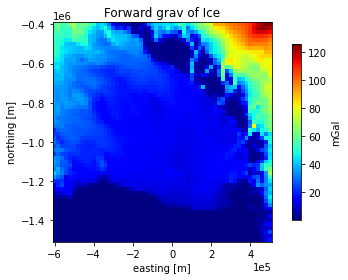

In [8]:
plt.pcolormesh(*coordinates[:2], ice_gravity, cmap='jet')
plt.colorbar(label="mGal", shrink=0.8)
plt.gca().set_aspect("equal")
plt.ticklabel_format(axis="both", style="sci", scilimits=(0, 0))
plt.title("Forward grav of Ice")
plt.xlabel("easting [m]")
plt.ylabel("northing [m]")
plt.tight_layout()
plt.show()

## Water Layer

In [10]:
water_density=surface.copy()
water_density.values[:] = 1030 #from Muto et al. 2013 

In [11]:
water_prisms=hm.prism_layer(
    coordinates=(list(surface.x), list(surface.y)),   
    surface=icebase, 
    reference=bed,
    properties={'density':water_density},
)

In [12]:
coordinates=vd.grid_coordinates(region=ris_300km_buffer,
        spacing=grav_spacing, extra_coords=grav_elev)
water_gravity=water_prisms.prism_layer.gravity(
     coordinates=coordinates,
     field = 'g_z',)

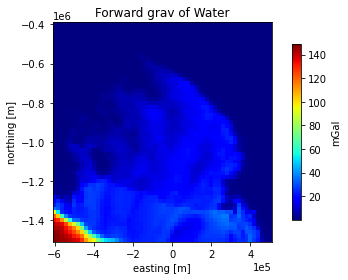

In [13]:
plt.pcolormesh(*coordinates[:2], water_gravity, cmap='jet')
plt.colorbar(label="mGal", shrink=0.8)
plt.gca().set_aspect("equal")
plt.ticklabel_format(axis="both", style="sci", scilimits=(0, 0))
plt.title("Forward grav of Water")
plt.xlabel("easting [m]")
plt.ylabel("northing [m]")
plt.tight_layout()
plt.show()

## Sediment Layer

In [17]:
sediment_density=bed.copy()
sediment_density.values[:] = 2400 #2178 from Muto et al. 2013

In [18]:
sediment_prisms=hm.prism_layer(
    coordinates=(list(bed.x), list(bed.y)),   
    surface=bed, 
    reference=basement,
    properties={'density':sediment_density},
)

In [19]:
coordinates=vd.grid_coordinates(region=ris_300km_buffer,
        spacing=grav_spacing, extra_coords=grav_elev)
sediment_gravity=sediment_prisms.prism_layer.gravity(
     coordinates=coordinates,
     field = 'g_z',)

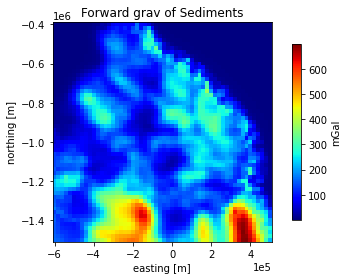

In [20]:
plt.pcolormesh(*coordinates[:2], sediment_gravity, cmap='jet')
plt.colorbar(label="mGal", shrink=0.8)
plt.gca().set_aspect("equal")
plt.ticklabel_format(axis="both", style="sci", scilimits=(0, 0))
plt.title("Forward grav of Sediments")
plt.xlabel("easting [m]")
plt.ylabel("northing [m]")
plt.tight_layout()
plt.show()

## Crust Layer

In [21]:
crust_density=basement.copy()
crust_density.values[:] = 2670 #from Muto et al. 2013

In [22]:
crust_prisms=hm.prism_layer(
    coordinates=(list(basement.x), list(basement.y)),   
    surface=basement, 
    reference=-50000,
    properties={'density':crust_density},
)

In [23]:
coordinates=vd.grid_coordinates(region=ris_300km_buffer,
        spacing=grav_spacing, extra_coords=grav_elev)
crust_gravity=crust_prisms.prism_layer.gravity(
     coordinates=coordinates,
     field = 'g_z',)

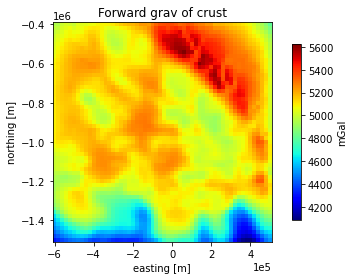

In [24]:
plt.pcolormesh(*coordinates[:2], crust_gravity, cmap='jet')
plt.colorbar(label="mGal", shrink=0.8)
# plt.plot()
plt.gca().set_aspect("equal")
plt.ticklabel_format(axis="both", style="sci", scilimits=(0, 0))
plt.title("Forward grav of crust")
plt.xlabel("easting [m]")
plt.ylabel("northing [m]")
plt.tight_layout()
plt.show()

## Add Gravity Grids Together

In [25]:
total_gravity=ice_gravity+water_gravity+sediment_gravity+crust_gravity

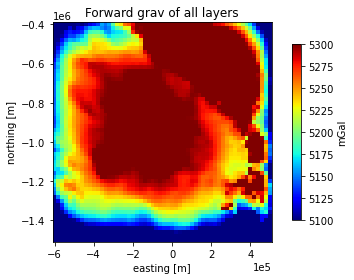

In [26]:
plt.pcolormesh(*coordinates[:2], total_gravity, cmap='jet', vmin=5100, vmax=5300)
plt.colorbar(label="mGal", shrink=0.8)
# plt.plot()
plt.gca().set_aspect("equal")
plt.ticklabel_format(axis="both", style="sci", scilimits=(0, 0))
plt.title("Forward grav of all layers")
plt.xlabel("easting [m]")
plt.ylabel("northing [m]")
plt.tight_layout()
plt.show()

### ROSETTA Gravity

In [150]:
risreg

'-760000/600000/-1600000/-350000'

In [151]:
aerograv_data = "D:/ROSETTA_Data/from_LDEO_2021/rs_2019_grav.csv"
gravity = pd.read_csv(aerograv_data)
gravity = pygmt.blockmedian(table=gravity[["x", "y", "FAG_levelled"]], 
                                         spacing="5000+e", 
                                         region=risreg)
pygmt.surface(x=gravity.x, y=gravity.y, z=gravity.FAG_levelled,
              spacing='5000+e',
              outfile="ROSETTA_gravity.nc",
              region=risreg,) 
!gmt grdmask ..\shapefiles\RIS_outline.shp -GRIS_mask.nc -I5000+e -R-760000/600000/-1600000/-350000 -NNaN/1/1
!gmt grdmath -Df ROSETTA_gravity.nc RIS_mask.nc MUL = ROSETTA_gravity.nc
!gmt grdsample ROSETTA_gravity.nc -GROSETTA_gravity.nc -T

In [165]:
gravity = xr.load_dataarray("../inversion_layers/RIS_Grav_5k.nc", drop_variables='polar_stereographic')
# gravity = xr.load_dataarray("ROSETTA_gravity.nc")
gravity

<xarray.DataArray 'Band1' (y: 183, x: 191)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * x        (x) float64 -5.75e+05 -5.7e+05 -5.65e+05 ... 3.7e+05 3.75e+05
  * y        (y) float64 -1.37e+06 -1.365e+06 -1.36e+06 ... -4.65e+05 -4.6e+05
Attributes:
    long_name:     GDAL Band Number 1
    grid_mapping:  polar_stereographic

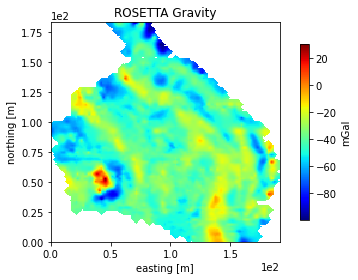

In [166]:
plt.pcolormesh(gravity, cmap='jet')
plt.colorbar(label="mGal", shrink=0.8)
plt.plot()
plt.gca().set_aspect("equal")
plt.ticklabel_format(axis="both", style="sci", scilimits=(0, 0))
plt.title("ROSETTA Gravity")
plt.xlabel("easting [m]")
plt.ylabel("northing [m]")
plt.tight_layout()
plt.show()